In [60]:
import pandas as pd
import numpy as np
import os
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
from collections import Counter
from difflib import SequenceMatcher

In [61]:
def cosine_similarity_list(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [62]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [63]:
def string_similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [64]:
def remove_non_alphanumeric(s):
    return ''.join([c if c.isalnum() else ' ' for c in s])

In [65]:
# Load data
tags = pd.read_csv('data/tags.dat', sep='\t', encoding = "ISO-8859-1")
artists = pd.read_csv('data/artists.dat', sep='\t', encoding = "ISO-8859-1")
user_tags = pd.read_csv('data/user_taggedartists-timestamps.dat', sep='\t', encoding = "ISO-8859-1")

In [66]:
# Merge with tags and artists to get good looking values
artists.rename(columns={'id': 'artistID', 'name': 'artistName'}, inplace=True)
tag_data = pd.merge(user_tags, tags, on='tagID')
tag_data = pd.merge(tag_data, artists, on='artistID')
tag_data = tag_data[['artistName', 'tagValue']]

In [67]:
# Data cleaning
tag_data['tagValue'] = tag_data['tagValue'].apply(lambda x: remove_non_alphanumeric(x))

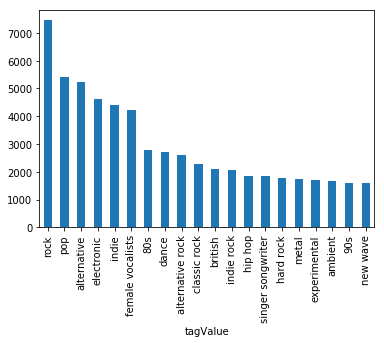

In [68]:
# Top 10 tags
tag_data.groupby('tagValue')['artistName'].count().sort_values(ascending=False).head(20).plot.bar()

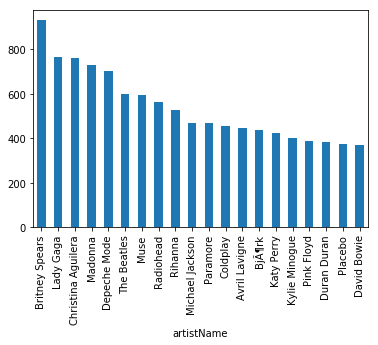

In [69]:
# Top 10 most tagged artists
tag_data.tagValue.groupby(tag_data.artistName).count().sort_values(ascending=False).head(20).plot.bar()

In [70]:
# Get a dictionary of artists for each tags
grouped_tags = tag_data[['artistName', 'tagValue']].groupby('tagValue')['artistName']
dico = grouped_tags.apply(list).to_dict()
reduced_dico = {k: v for k, v in dico.items() if len(v) > 5} # Take only tags with more than 5 artists

In [77]:
# Compute tag similarities using cosine similarity
similarities = {}

for tag1 in reduced_dico:
    for tag2 in reduced_dico:
        
        if tag1 == tag2 or tag1+'//'+tag2 in similarities or tag2+'//'+tag1 in similarities or len(tag1) < 10 or len(tag2) < 10:
            continue
            
        score = cosine_similarity_list(Counter(tag1), Counter(tag2))
        similarities[tag1+'//'+tag2] = score

In [78]:
# Remove tag that are too similar (similarity > 0.95) to remove false-positive
similarities = {k: v for k, v in similarities.items() if v < 0.95}
#Remove tags labels that are too similar
similarities = {k: v for k, v in similarities.items() if string_similarity(k.split('//')[0], k.split('//')[1]) < 0.8}

In [79]:
sorted_similarities = sorted(similarities.items(), key=lambda x:x[1], reverse=True)
sorted_similarities

[('i have a definite favorite part in this song//i listened to it over and over again',
  0.9496549543277889),
 ('this light//this light   this light', 0.9490707529566208),
 ('italian rock//latin rock', 0.9486832980505138),
 ('grave stompers//progressive metal', 0.9467292624062573),
 ('album favourite//favorite albums', 0.9459053029269171),
 ('lastfm hipster artists//lms artist', 0.9456108576893003),
 ('the fact that this is the name of a band makes me want to check their music out even though i do not care much for indie pop//the worst thing ever to happen to music',
  0.9455604195619937),
 ('i listened to it over and over again//i love dancing about to this like a complete and utter idiot',
  0.9449891063925625),
 ('singer songwriter//songwriters', 0.9438798074485389),
 ('progressive deathcore//progressive trance', 0.9435367655300861),
 ('progressive metalcore//progressive trance', 0.9435367655300861),
 ('celine dion//indie electronic', 0.9432422182837986),
 ('avant garde//avant gard

In [82]:
# Manual cleaning: to be improved
false_positives = []

false_positives.append('album favourite//favorite albums')
false_positives.append('favorite bands//favorite bands and artists')
false_positives.append('this light//this light   this light')

filtered_similarities = [i for i in sorted_similarities if i[0] not in false_positives]

In [83]:
# Top 30 most similar tags
filtered_similarities[:30]

[('i have a definite favorite part in this song//i listened to it over and over again',
  0.9496549543277889),
 ('italian rock//latin rock', 0.9486832980505138),
 ('grave stompers//progressive metal', 0.9467292624062573),
 ('lastfm hipster artists//lms artist', 0.9456108576893003),
 ('the fact that this is the name of a band makes me want to check their music out even though i do not care much for indie pop//the worst thing ever to happen to music',
  0.9455604195619937),
 ('i listened to it over and over again//i love dancing about to this like a complete and utter idiot',
  0.9449891063925625),
 ('singer songwriter//songwriters', 0.9438798074485389),
 ('progressive deathcore//progressive trance', 0.9435367655300861),
 ('progressive metalcore//progressive trance', 0.9435367655300861),
 ('celine dion//indie electronic', 0.9432422182837986),
 ('avant garde//avant garde metal', 0.9429080709444059),
 ('could be mistaken for sth else//really talented female artist who doesnt rely on her se